In [9]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import matplotlib.cm as cmap
cm = cmap.inferno

import numpy as np
import scipy as sp
import theano
import theano.tensor as tt
import theano.tensor.nlinalg
import sys
sys.path.insert(0, "../../..")
import pymc3 as pm

In [2]:
np.random.seed(20090425)
n = 20
X = np.sort(3 * np.random.rand(n))[:, None]

with pm.Model() as model:
    # f(x)
    l_true = 0.3
    s2_f_true = 1.0
    cov = s2_f_true * pm.gp.cov.ExpQuad(1, l_true)

    # noise, epsilon
    s2_n_true = 0.1
    K_noise = s2_n_true ** 2 * tt.eye(n)
    K = cov(X) + K_noise

# evaluate the covariance with the given hyperparameters
K = theano.function([], cov(X) + K_noise)()

# generate fake data from GP with white noise (with variance sigma2)
y = np.random.multivariate_normal(np.zeros(n), K)

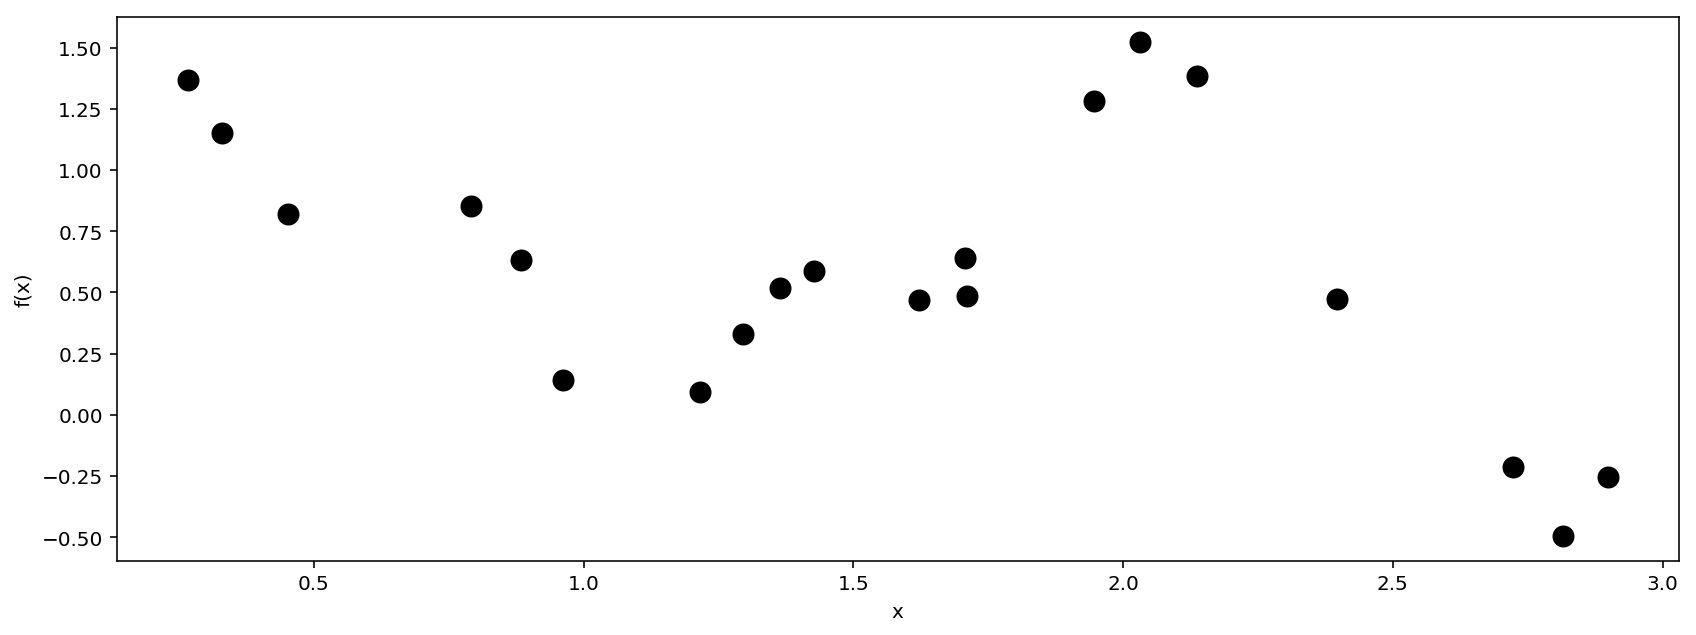

In [10]:
fig = plt.figure(figsize=(14,5)); ax = fig.add_subplot(111)
ax.plot(X, y, 'ok', ms=10);
ax.set_xlabel("x");
ax.set_ylabel("f(x)");

In [30]:
Z = np.linspace(0,3,100)[:, None]

from pymc3.gp.mean import Mean

class MyMean(Mean):
    
    def __call__(self, X):
#         return tt.squeeze(tt.dot(tt.transpose(X), X))
        return X[0] * X[0]
    

with pm.Model() as model:
    # priors on the covariance function hyperparameters
    l = pm.Uniform('l', 0, 10)

    # uninformative prior on the function variance
    log_s2_f = pm.Uniform('log_s2_f', lower=-10, upper=5)
    s2_f = pm.Deterministic('s2_f', tt.exp(log_s2_f))

    # uninformative prior on the noise variance
    log_s2_n = pm.Uniform('log_s2_n', lower=-10, upper=5)
    s2_n = pm.Deterministic('s2_n', tt.exp(log_s2_n))

    # covariance functions for the function f and the noise
    f_cov = s2_f * pm.gp.cov.ExpQuad(1, l)

    y_obs = pm.gp.GP('y_obs', mean_func=MyMean(), cov_func=f_cov, sigma=s2_n, observed={'X': X, 'Y': y})

In [31]:
with model:
    trace = pm.sample(2000, burn=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 27.439:   6%|▌         | 12001/200000 [00:10<02:49, 1106.11it/s]
Convergence archived at 12100
Interrupted at 12,100 [6%]: Average Loss = 9,349.4
100%|██████████| 2500/2500 [00:41<00:00, 60.67it/s]


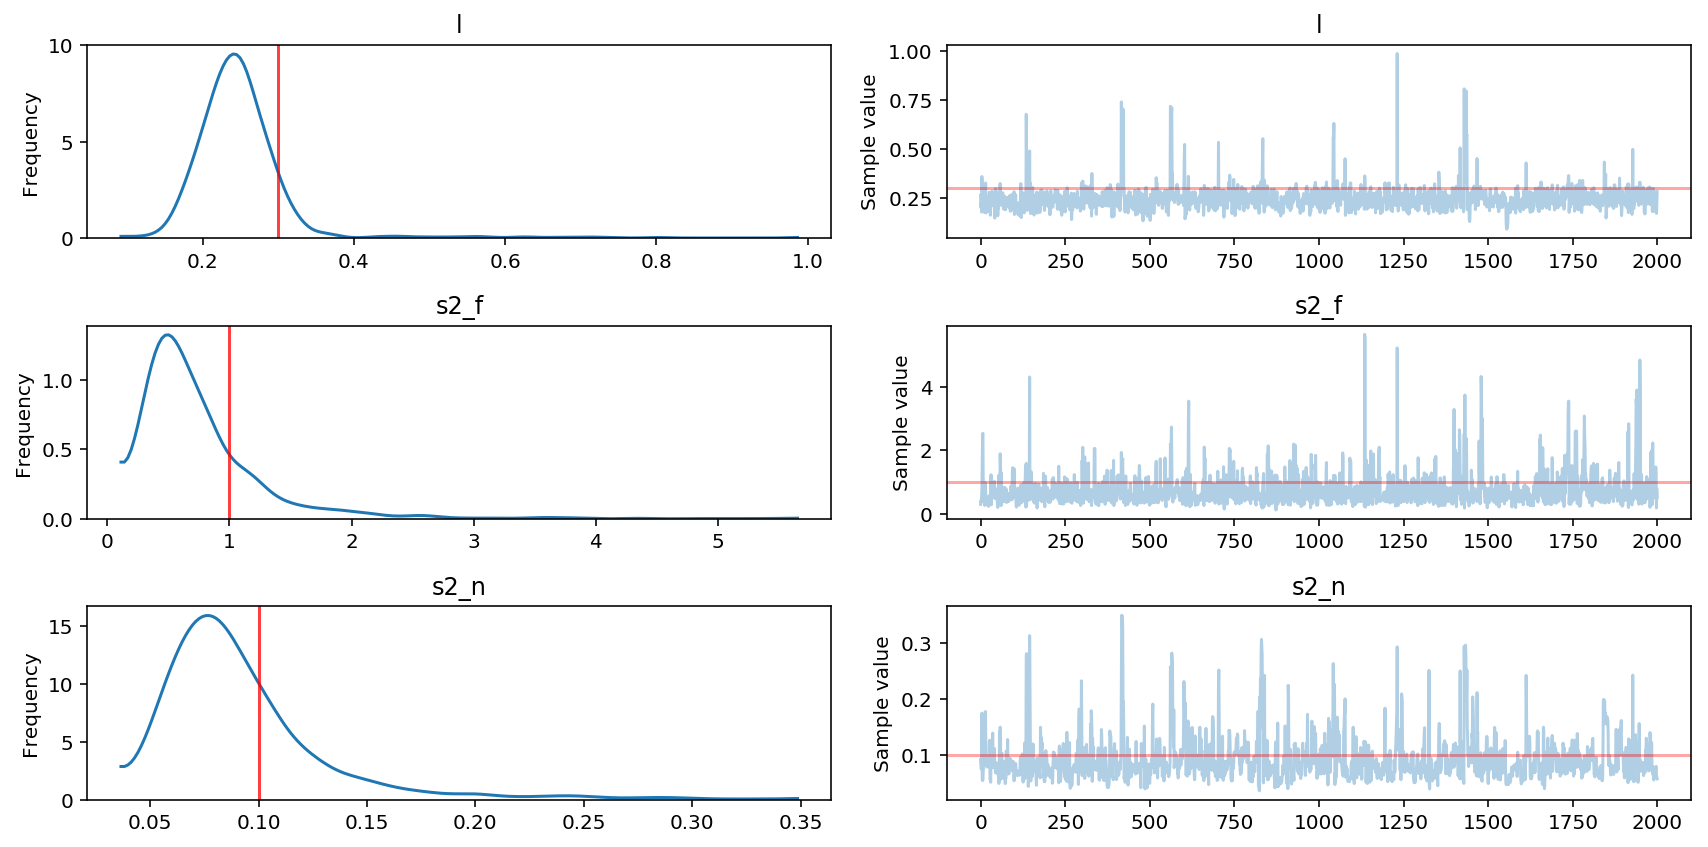

In [32]:
pm.traceplot(trace, varnames=['l', 's2_f', 's2_n'],
             lines={"l": l_true,
                    "s2_f": s2_f_true,
                    "s2_n": s2_n_true});

In [37]:
sample_locs = np.linspace(-5, 8, 100)[:, None]
with model:
    gp_samples = pm.gp.sample_gp(trace, y_obs, sample_locs, samples=50, random_seed=42)

100%|██████████| 50/50 [00:00<00:00, 73.28it/s]


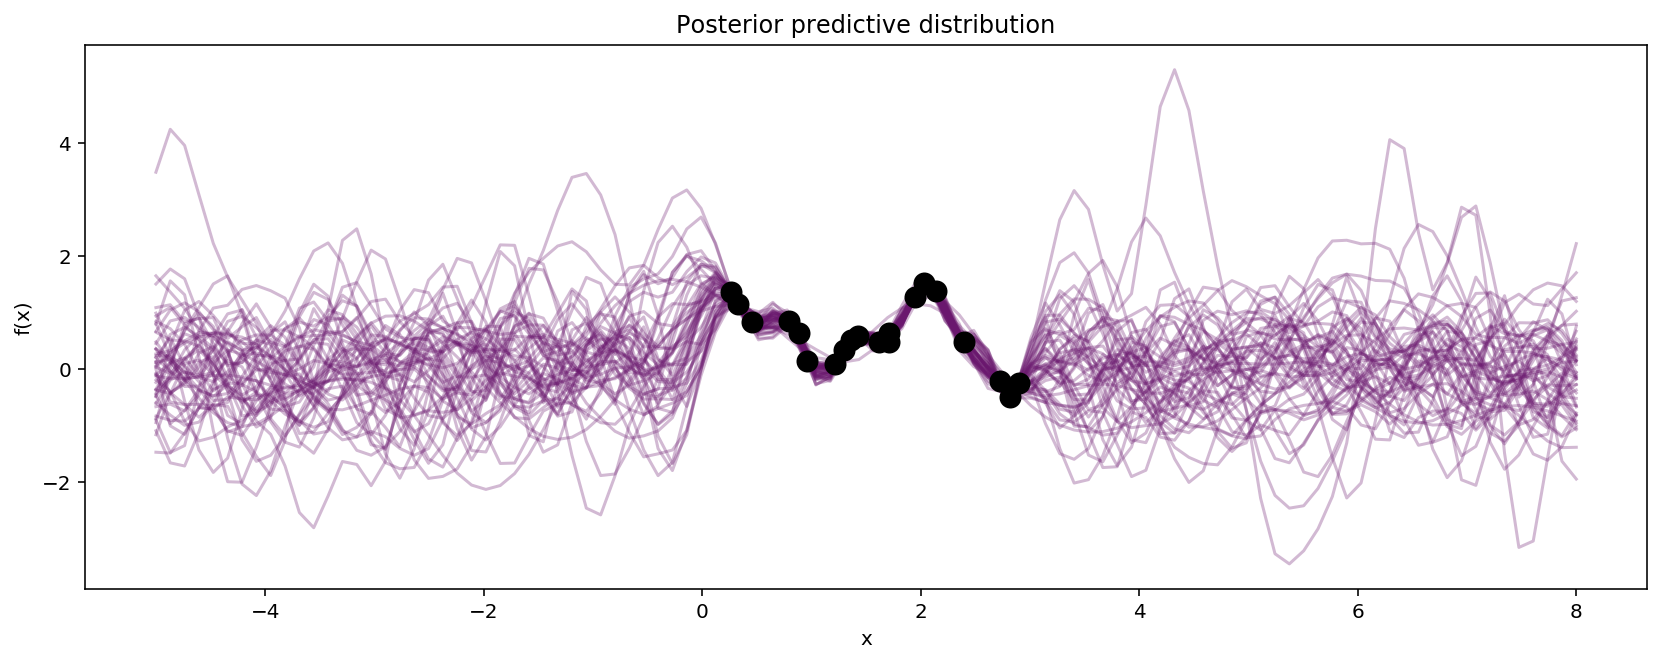

In [38]:
fig, ax = plt.subplots(figsize=(14,5))

[ax.plot(sample_locs, x, color=cm(0.3), alpha=0.3) for x in gp_samples]
# overlay the observed data
ax.plot(X, y, 'ok', ms=10);
ax.set_xlabel("x");
ax.set_ylabel("f(x)");
ax.set_title("Posterior predictive distribution");